In [1]:
using Convex, JuMP, Mosek, SCS, CPLEX, Pajarito, LinearAlgebra, Plots 

# Utilities, Plotting and Solvers

In [2]:
function plot_and_check(points, D_val, z_val)
    n_points = size(points,2)
    c=inv(D_val)*(z_val)
    println("Max violation (big-M): ",
            max(0,maximum(((points[:,i] - c)'*D_val*(points[:,i] - c))[1] for i in 1:n_points) - 1),
            " (",get_bigM(points),")")
    println("Log Det: ",log(det(D_val)))
    println("Root Det: ",(det(D_val)^(1/size(points,1))))
    t = 0:0.01:2pi
    ellipse=inv(cholesky(Symmetric(D_val)).U)*[cos.(t) sin.(t)]'
    plot(ellipse[1,:].+c[1],ellipse[2,:].+c[2],legend=false,linewidth=3)
    scatter!(points[1,:],points[2,:],legend=false)
end

plot_and_check (generic function with 1 method)

In [4]:
function get_bigM(points)
   1000
end

get_bigM (generic function with 1 method)

In [5]:
function Pajarito_SCS_CPLEX(;log_level=3,root_only=true,time_limit=Inf)
    mip_solver_drives = true
    rel_gap = 1e-5
    if isinf(time_limit)
        MIPsolver = CplexSolver(
            CPX_PARAM_SCRIND = mip_solver_drives && log_level > 0 ? 1 : 0,
            CPX_PARAM_EPINT = 1e-8,
            CPX_PARAM_EPRHS = 1e-7,
            CPX_PARAM_EPGAP = (mip_solver_drives ? 1e-5 : 1e-9)
        )
    else
        MIPsolver = CplexSolver(
            CPX_PARAM_SCRIND = mip_solver_drives && log_level > 0 ? 1 : 0,
            CPX_PARAM_EPINT = 1e-8,
            CPX_PARAM_EPRHS = 1e-7,
            CPX_PARAM_EPGAP = (mip_solver_drives ? 1e-5 : 1e-9),
            CPX_PARAM_TILIM = time_limit
        )
    end
    
    CPsolver = SCSSolver(eps=1e-6, max_iters=1000000, verbose=log_level)
    MICPsolver = PajaritoSolver(mip_solver_drives=mip_solver_drives,
        timeout = time_limit,
        log_level = log_level,
        rel_gap = rel_gap,
        mip_solver = MIPsolver,
        cont_solver = CPsolver,
        solve_subp = !root_only,
        solve_relax = true,
        init_sdp_soc = false,
        sdp_soc = false,
        sdp_eig = true,
        # prim_cuts_only=true,
        prim_cuts_always = true,
        # prim_cuts_assist=true
    )
end

Pajarito_SCS_CPLEX (generic function with 1 method)

In [6]:
function Pajarito_Mosek_CPLEX(;log_level=3,root_only=true,time_limit=Inf)
    mip_solver_drives = true
    rel_gap = 1e-5
    if isinf(time_limit)
        MIPsolver = CplexSolver(
            CPX_PARAM_SCRIND = mip_solver_drives && log_level > 0 ? 1 : 0,
            CPX_PARAM_EPINT = 1e-8,
            CPX_PARAM_EPRHS = 1e-7,
            CPX_PARAM_EPGAP = (mip_solver_drives ? 1e-5 : 1e-9)
        )
    else
        MIPsolver = CplexSolver(
            CPX_PARAM_SCRIND = mip_solver_drives && log_level > 0 ? 1 : 0,
            CPX_PARAM_EPINT = 1e-8,
            CPX_PARAM_EPRHS = 1e-7,
            CPX_PARAM_EPGAP = (mip_solver_drives ? 1e-5 : 1e-9),
            CPX_PARAM_TILIM = time_limit
        )
    end
    
    CPsolver = MosekSolver(MSK_IPAR_LOG=0)
    MICPsolver = PajaritoSolver(mip_solver_drives=mip_solver_drives,
        timeout = time_limit,
        log_level = log_level,
        rel_gap = rel_gap,
        mip_solver = MIPsolver,
        cont_solver = CPsolver,
        solve_subp = !root_only,
        solve_relax = true,
        init_sdp_soc = false,
        sdp_soc = false,
        sdp_eig = true,
        # prim_cuts_only=true,
        prim_cuts_always = true,
        # prim_cuts_assist=true
    )
end

Pajarito_Mosek_CPLEX (generic function with 1 method)

# Instances

In [ ]:
dim = 2
original = 9 
noise = 1 
points = [randn(dim,original)  randn(dim,noise).+10*ones(dim)]

In [7]:
dim = 2
original = 90
noise = 10
points = [randn(dim,original)  10*rand([-1,1],dim,noise) + randn(dim,noise) ]


2×100 Array{Float64,2}:
  0.2277    -1.06985    0.358735   1.17819  …   9.57702  -10.2051    -9.75261
 -0.853595   0.565372  -0.75473   -1.21866     -8.47456   -9.63078  -10.0962 

# Models

## SDP + EXP and SDP + SOCP with Convex.jl

In [8]:
function Convexjl_base(points, fraction)
    n_points = size(points,2)
    dim = size(points,1)
    A = Convex.Semidefinite(dim)
    z = Convex.Variable(dim)
    s = Convex.Variable()
    t = Convex.Variable()
    model = Convex.maximize(
        t,
        [s z'; z A] in :SDP
    )
    if fraction ≈ 1
        for i in 1:n_points
            model.constraints += points[:,i]'*A*points[:,i] - 2*points[:,i]'*z + s <= 1
        end
    else
        M = get_bigM(points)
        np = Convex.Variable(n_points, :Bin)
        for i in 1:n_points
            model.constraints += points[:,i]'*A*points[:,i] - 2*points[:,i]'*z + s <= 1 + M*np[i]
        end
        model.constraints += sum(np) <= (1-fraction)*n_points
    end
        
    model, A, z, t
end

Convexjl_base (generic function with 1 method)

In [9]:
function Convexjl_add_logdet(model, A, t)
    model.constraints += t <= logdet(A)
end

Convexjl_add_logdet (generic function with 1 method)

In [10]:
function Convexjl_add_diagdet(model, A, t)
    D = Convex.Variable(size(A)) # diagonal matrix
    U = Convex.Variable(size(A)) # upper triangular matrix
    model.constraints += [D U; U' A] in :SDP
    model.constraints += diag(D) == diag(U)
    for i in 1:A.size[1]
        for j in 1:A.size[2]
            if i != j
                model.constraints += D[i,j] == 0
            end
            if i > j
                model.constraints += U[i,j] == 0
            end
        end
    end
    D
end

Convexjl_add_diagdet (generic function with 1 method)

In [11]:
function Convexjl_add_logdet_SDP_EXP(model, A, t)
    D = Convexjl_add_diagdet(model, A, t)
    model.constraints += t <= sum(log(diag(D)))
end

Convexjl_add_logdet_SDP_EXP (generic function with 1 method)

In [12]:
function Convexjl_add_geomean(model, A, t)
    D = Convexjl_add_diagdet(model, A, t)
    x = diag(D)
    if length(x) == 2
        model.constraints += t <= geomean(x[1],x[2]) 
    else
        u = Convex.Variable(ceil(Int64, length(x)/2), Positive())
        for i in 1:length(floor(Int64, length(x)/2))
            model.constraints += u[i] <= geomean(x[2*i-1],x[2*i]) 
        end
        if !isinteger(length(x)/2)
            model.constraints += u[end] <= geomean(x[end],t) 
        end
        addGeoMean(model,u,t)
    end
end

Convexjl_add_geomean (generic function with 1 method)

## SDP + SOCP with JuMP.jl

In [13]:
function addGeoMean(model,x,t)
    setlowerbound.(x,0) 
    if length(x) == 2
        @constraint(model,norm([t (x[1]-x[2])/2]) <= (x[1]+x[2])/2) # @constraint(model, t^2 <= x[1]*x[2])
    else
        u = @variable(model, [1:floor(Int64, length(x)/2)], lowerbound = 0)
        for i in 1:length(u)
            @constraint(model,norm([u[i] (x[2*i-1]-x[2*i])/2]) <= (x[2*i-1]+x[2*i])/2) # @constraint(model, u[i]^2 <= x[2*i-1]*x[2*i])
        end
        if !isinteger(length(x)/2)
            push!(u,@variable(model, lowerbound = 0))
            @constraint(model, norm([u[end] (x[end]-t)/2]) <= (x[end]+t)/2) # @constraint(model, u[end]^2 <= x[end]*t)
        end
        addGeoMean(model,u,t)
    end
end

addGeoMean (generic function with 1 method)

In [14]:
function JuMPjl( points, fraction, solver)
    n_points = size(points,2)
    dim = size(points,1)
    
    model = Model(solver=solver)
    @variable(model, A[1:dim,1:dim], SDP)
    @variable(model, z[1:dim])
    @variable(model, s)
    @variable(model, U[1:dim,1:dim]) # upper triangular matrix
    @variable(model, D[1:dim,1:dim]) # diagonal matrix
    @SDconstraint(model, [s z'; z A] >= 0)
    @SDconstraint(model, [D U; U' A] >= 0)
    @constraint(model, diag(D) .== diag(U))
    for i in 1:dim
        for j in 1:dim
            if i != j
                setupperbound(D[i,j],0) 
                setlowerbound(D[i,j],0) 
            end
            if i > j
                setupperbound(U[i,j],0) 
                setlowerbound(U[i,j],0) 
            end
        end
    end
    
    if fraction ≈ 1
        for i in 1:n_points
            @constraint(model, points[:,i]'*A*points[:,i] - 2*points[:,i]'*z + s <= 1)
        end
    else
        M = get_bigM(points)
        @variable(model, np[1:n_points], Bin)
        for i in 1:n_points
            @constraint(model, points[:,i]'*A*points[:,i] - 2*points[:,i]'*z + s <= 1 + M*np[i])
        end
        @constraint(model, sum(np) <= (1-fraction)*n_points)
    end
    @variable(model, t >= 0)
    addGeoMean(model, diag(D), t)
    @objective(model, Max, t)
    model, A, z, t
end

JuMPjl (generic function with 1 method)

## Solve for all points

  8.067891 seconds (47.48 k allocations: 4.834 MiB)
Max violation (big-M): 6.262040387561285e-6 (1000)
Log Det: -10.600804760240285
Root Det: 0.004989585792793946


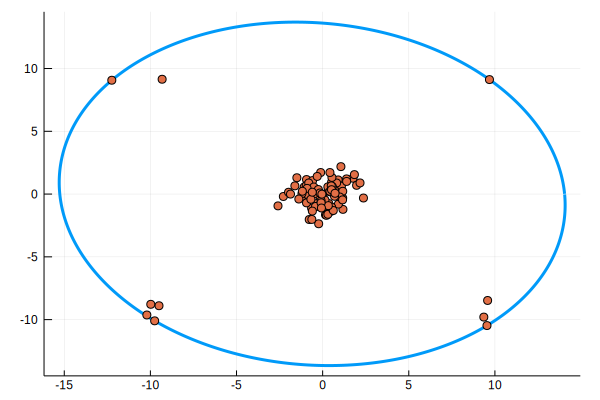

In [20]:
model, A, z, t = Convexjl_base(points, 1);
Convexjl_add_logdet(model, A, t)
@time solve!(model, SCSSolver(verbose=0, max_iters=1000000, eps=1e-6))
plot_and_check(points, A.value, z.value)

 16.091894 seconds (47.39 k allocations: 4.836 MiB)
Max violation (big-M): 5.832841470487793e-6 (1000)
Log Det: -10.600799965580851
Root Det: 0.0049895977544905795


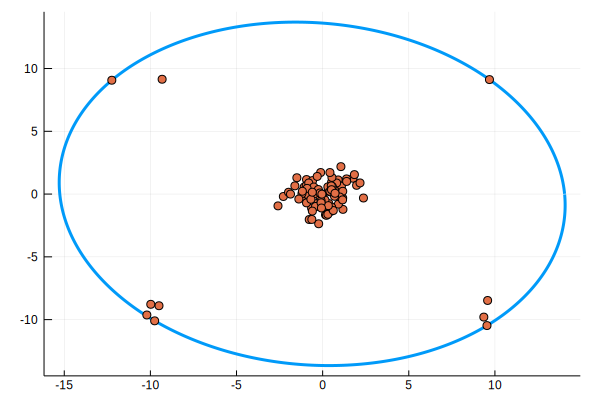

In [21]:
model, A, z, t = Convexjl_base(points, 1);
Convexjl_add_logdet_SDP_EXP(model, A, t)
@time solve!(model, SCSSolver(verbose=0, max_iters=1000000, eps=1e-6))
plot_and_check(points, A.value, z.value)

  0.169463 seconds (47.56 k allocations: 4.804 MiB)
Max violation (big-M): 4.4233169063101485e-6 (1000)
Log Det: -10.60079737899822
Root Det: 0.004989604207498199


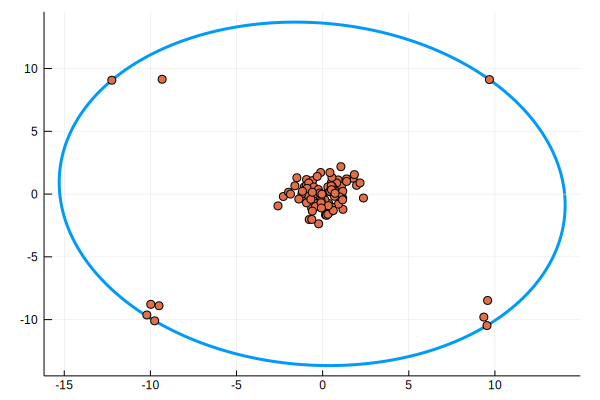

In [22]:
model, A, z, t = Convexjl_base(points, 1);
Convexjl_add_geomean(model, A, t)
@time solve!(model, SCSSolver(verbose=0, max_iters=1000000, eps=1e-6))
plot_and_check(points, A.value, z.value)

  0.044384 seconds (1.82 k allocations: 435.992 KiB)
Max violation (big-M): 1.5419465309030045e-6 (1000)
Log Det: -10.600801381705548
Root Det: 0.004989594221545525


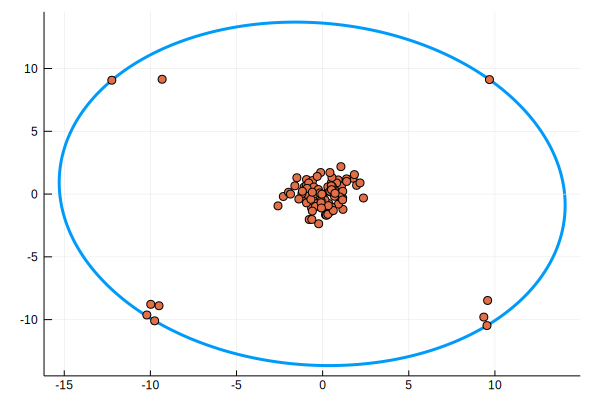

In [23]:
model, A, z, t = JuMPjl( points, 1, SCSSolver(verbose=0, max_iters=1000000, eps=1e-6));
@time solve(model)
plot_and_check(points, getvalue(A), getvalue(z))

  0.014060 seconds (4.53 k allocations: 428.352 KiB)
Max violation (big-M): 0.0 (1000)
Log Det: -10.600802528964316
Root Det: 0.004989591359368488


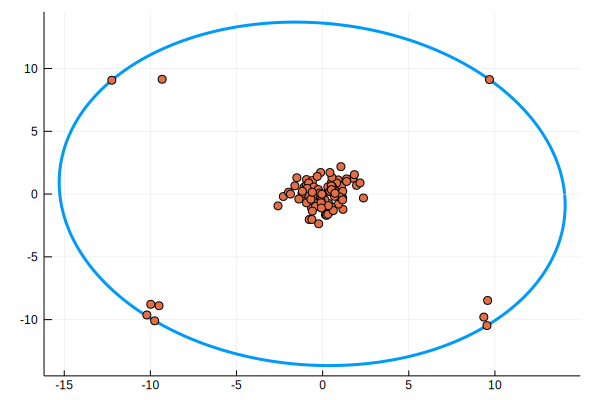

In [24]:
model, A, z, t = JuMPjl( points, 1,MosekSolver(MSK_IPAR_LOG=0));
@time solve(model)
plot_and_check(points, getvalue(A), getvalue(z))

## Solve for 90%

  2.892538 seconds (78.35 k allocations: 9.924 MiB)
Max violation (big-M): 53.28720727137946 (1000)
Log Det: -3.4795422706326726
Root Det: 0.17556057563510666


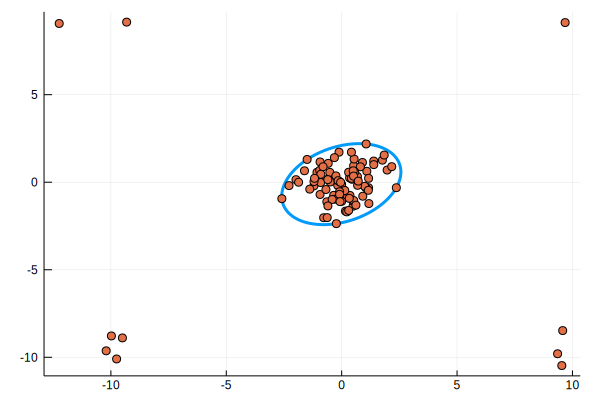

In [37]:
model, A, z, t = Convexjl_base(points, 0.9);
Convexjl_add_logdet(model, A, t)
@time Convex.solve!(model, Pajarito_SCS_CPLEX(log_level=0,time_limit=60, root_only=true))
plot_and_check(points, A.value, z.value)

 15.943982 seconds (99.87 k allocations: 11.336 MiB)
Max violation (big-M): 53.28724989277789 (1000)
Log Det: -3.4795417490498783
Root Det: 0.17556062141980044


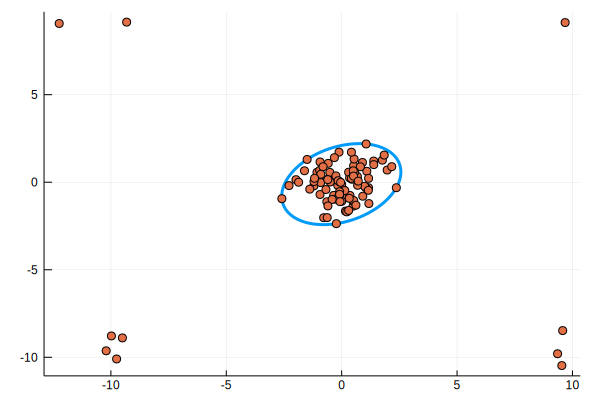

In [33]:
model, A, z, t = Convexjl_base(points, 0.9);
Convexjl_add_geomean(model, A, t)
@time Convex.solve!(model, Pajarito_SCS_CPLEX(log_level=0,time_limit=60, root_only=false))
plot_and_check(points, A.value, z.value)

  0.938582 seconds (16.93 k allocations: 2.470 MiB, 1.73% gc time)
Max violation (big-M): 32.38041646032735 (1000)
Log Det: -3.8050295167398107
Root Det: 0.1491929628260747


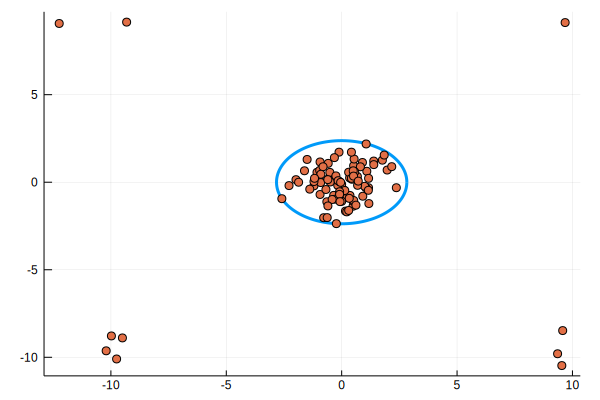

In [34]:
model, A, z, t = JuMPjl( points, 0.9, Pajarito_SCS_CPLEX(log_level=0, time_limit=60, root_only=false));
@time solve(model)
plot_and_check(points, getvalue(A), getvalue(z)) 

  0.809626 seconds (136.35 k allocations: 8.274 MiB, 1.75% gc time)
Max violation (big-M): 32.38041742671717 (1000)
Log Det: -3.8050294614719005
Root Det: 0.14919296694886638


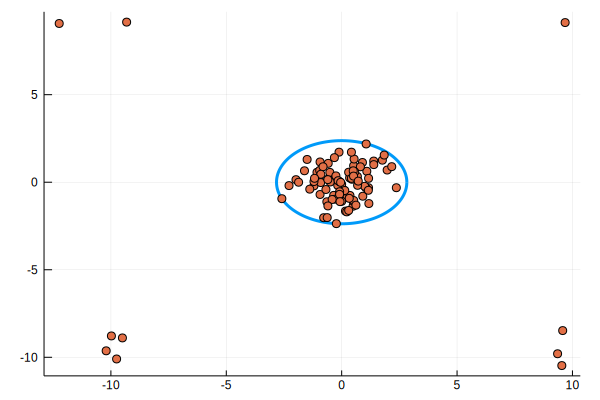

In [35]:
model, A, z, t = JuMPjl( points, 0.9,Pajarito_Mosek_CPLEX(log_level=0, time_limit=60, root_only=false));
@time solve(model)
plot_and_check(points, getvalue(A), getvalue(z))